In [186]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm_notebook as tqdm

In [187]:
'''
Non-parametric computation of entropy and mutual-information
Adapted by G Varoquaux for code created by R Brette, itself
from several papers (see in the code).
These computations rely on nearest-neighbor statistics
'''
import numpy as np

from scipy.special import gamma,psi
from scipy import ndimage
from scipy.linalg import det
from numpy import pi

from sklearn.neighbors import NearestNeighbors

__all__=['entropy', 'mutual_information', 'entropy_gaussian']

EPS = np.finfo(float).eps


def nearest_distances(X, k=1):
    '''
    X = array(N,M)
    N = number of points
    M = number of dimensions
    returns the distance to the kth nearest neighbor for every point in X
    '''
    knn = NearestNeighbors(n_neighbors=k + 1)
    knn.fit(X)
    d, _ = knn.kneighbors(X) # the first nearest neighbor is itself
    return d[:, -1] # returns the distance to the kth nearest neighbor


def entropy_gaussian(C):
    '''
    Entropy of a gaussian variable with covariance matrix C
    '''
    if np.isscalar(C): # C is the variance
        return .5*(1 + np.log(2*pi)) + .5*np.log(C)
    else:
        n = C.shape[0] # dimension
        return .5*n*(1 + np.log(2*pi)) + .5*np.log(abs(det(C)))


def entropy(X, k=1):
    ''' Returns the entropy of the X.
    Parameters
    ===========
    X : array-like, shape (n_samples, n_features)
        The data the entropy of which is computed
    k : int, optional
        number of nearest neighbors for density estimation
    Notes
    ======
    Kozachenko, L. F. & Leonenko, N. N. 1987 Sample estimate of entropy
    of a random vector. Probl. Inf. Transm. 23, 95-101.
    See also: Evans, D. 2008 A computationally efficient estimator for
    mutual information, Proc. R. Soc. A 464 (2093), 1203-1215.
    and:
    Kraskov A, Stogbauer H, Grassberger P. (2004). Estimating mutual
    information. Phys Rev E 69(6 Pt 2):066138.
    '''

    # Distance to kth nearest neighbor
    r = nearest_distances(X, k) # squared distances
    n, d = X.shape
    volume_unit_ball = (pi**(.5*d)) / gamma(.5*d + 1)
    '''
    F. Perez-Cruz, (2008). Estimation of Information Theoretic Measures
    for Continuous Random Variables. Advances in Neural Information
    Processing Systems 21 (NIPS). Vancouver (Canada), December.
    return d*mean(log(r))+log(volume_unit_ball)+log(n-1)-log(k)
    '''
    return (d*np.mean(np.log(r + np.finfo(X.dtype).eps))
            + np.log(volume_unit_ball) + psi(n) - psi(k))


def mutual_information(variables, k=1):
    '''
    Returns the mutual information between any number of variables.
    Each variable is a matrix X = array(n_samples, n_features)
    where
      n = number of samples
      dx,dy = number of dimensions
    Optionally, the following keyword argument can be specified:
      k = number of nearest neighbors for density estimation
    Example: mutual_information((X, Y)), mutual_information((X, Y, Z), k=5)
    '''
    if len(variables) < 2:
        raise AttributeError(
                "Mutual information must involve at least 2 variables")
    all_vars = np.hstack(variables)
    return (sum([entropy(X, k=k) for X in variables])
            - entropy(all_vars, k=k))


def mutual_information_2d(x, y, sigma=1, normalized=False):
    """
    Computes (normalized) mutual information between two 1D variate from a
    joint histogram.
    Parameters
    ----------
    x : 1D array
        first variable
    y : 1D array
        second variable
    sigma: float
        sigma for Gaussian smoothing of the joint histogram
    Returns
    -------
    nmi: float
        the computed similariy measure
    """
    bins = (256, 256)

    jh = np.histogram2d(x, y, bins=bins)[0]

    # smooth the jh with a gaussian filter of given sigma
    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                 output=jh)

    # compute marginal histograms
    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    # Normalised Mutual Information of:
    # Studholme,  jhill & jhawkes (1998).
    # "A normalized entropy measure of 3-D medical image alignment".
    # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
                / np.sum(jh * np.log(jh))) - 1
    else:
        mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
               - np.sum(s2 * np.log(s2)))

    return mi



###############################################################################
# Tests

def test_entropy():
    # Testing against correlated Gaussian variables
    # (analytical results are known)
    # Entropy of a 3-dimensional gaussian variable
    rng = np.random.RandomState(0)
    n = 50000
    d = 3
    P = np.array([[1, 0, 0], [0, 1, .5], [0, 0, 1]])
    C = np.dot(P, P.T)
    Y = rng.randn(d, n)
    X = np.dot(P, Y)
    H_th = entropy_gaussian(C)
    H_est = entropy(X.T, k=5)
    # Our estimated entropy should always be less that the actual one
    # (entropy estimation undershoots) but not too much
    np.testing.assert_array_less(H_est, H_th)
    np.testing.assert_array_less(.9*H_th, H_est)


def test_mutual_information():
    # Mutual information between two correlated gaussian variables
    # Entropy of a 2-dimensional gaussian variable
    n = 50000
    rng = np.random.RandomState(0)
    #P = np.random.randn(2, 2)
    P = np.array([[1, 0], [0.5, 1]])
    C = np.dot(P, P.T)
    U = rng.randn(2, n)
    Z = np.dot(P, U).T
    X = Z[:, 0]
    X = X.reshape(len(X), 1)
    Y = Z[:, 1]
    Y = Y.reshape(len(Y), 1)
    # in bits
    MI_est = mutual_information((X, Y), k=5)
    MI_th = (entropy_gaussian(C[0, 0])
             + entropy_gaussian(C[1, 1])
             - entropy_gaussian(C)
            )
    # Our estimator should undershoot once again: it will undershoot more
    # for the 2D estimation that for the 1D estimation
    print((MI_est, MI_th))
    np.testing.assert_array_less(MI_est, MI_th)
    np.testing.assert_array_less(MI_th, MI_est  + .3)


def test_degenerate():
    # Test that our estimators are well-behaved with regards to
    # degenerate solutions
    rng = np.random.RandomState(0)
    x = rng.randn(50000)
    X = np.c_[x, x]
    assert np.isfinite(entropy(X))
    assert np.isfinite(mutual_information((x[:, np.newaxis],
                                           x[:,  np.newaxis])))
    assert 2.9 < mutual_information_2d(x, x) < 3.1


def test_mutual_information_2d():
    # Mutual information between two correlated gaussian variables
    # Entropy of a 2-dimensional gaussian variable
    n = 50000
    rng = np.random.RandomState(0)
    #P = np.random.randn(2, 2)
    P = np.array([[1, 0], [.9, .1]])
    C = np.dot(P, P.T)
    U = rng.randn(2, n)
    Z = np.dot(P, U).T
    X = Z[:, 0]
    X = X.reshape(len(X), 1)
    Y = Z[:, 1]
    Y = Y.reshape(len(Y), 1)
    # in bits
    MI_est = mutual_information_2d(X.ravel(), Y.ravel())
    MI_th = (entropy_gaussian(C[0, 0])
             + entropy_gaussian(C[1, 1])
             - entropy_gaussian(C)
            )
    print((MI_est, MI_th))
    # Our estimator should undershoot once again: it will undershoot more
    # for the 2D estimation that for the 1D estimation
    np.testing.assert_array_less(MI_est, MI_th)
    np.testing.assert_array_less(MI_th, MI_est  + .2)

In [188]:
def matrix_minor(arr, i, j):
    return np.delete(np.delete(arr,i,axis=0), j, axis=1)

In [219]:
N = 400

sigm_e = 0.001

W = np.random.normal(0.,1./N**.5,(N,N))
W[range(N),range(N)] = 0.

T = 100000

y = np.ndarray((T,N))
X_r = np.ndarray((T,N))
X_e = np.random.normal(0.,sigm_e,(T,N))

a = np.ones((T,N))*0.3

y[0,:] = 0.1

for t in tqdm(range(1,T)):
    
    X_r[t,:] = W @ y[t-1,:]
    
    y[t,:] = np.tanh(a[t-1,:] * X_r[t,:] + X_e[t,:])
    
    a[t,:] = a[t-1,:] + 0.005 * (1. - 2.*y[t,:]*X_r[t,:])
    

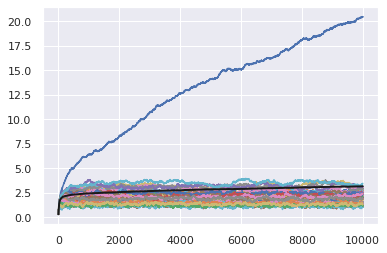

In [220]:
plt.plot(a[::10,:50])
plt.plot((a[::10,:]**2.).mean(axis=1)**.5,c='k',lw='2')

plt.show()

In [141]:
autocorr = np.ndarray((100,100))

for n in tqdm(range(100)):
    for t in range(1,101):
        autocorr[n,t-1] = (y[t:,n]*y[:-t,n]).mean()

100%|██████████| 100/100 [00:00<00:00, 165.27it/s]


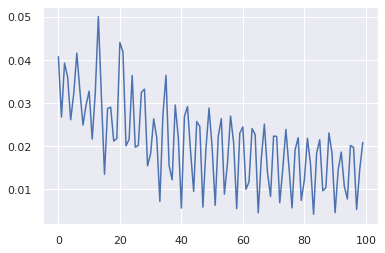

In [142]:
plt.plot(np.abs(autocorr).mean(axis=0))
plt.show()

In [137]:
autocorr.mean()

-0.00010400601603827481

In [ ]:
W = np.random.